## Import Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, log_loss

## Import Data

In [3]:
data = load_boston()

## Reshape the data 

In [4]:
x = pd.DataFrame(data['data'],columns=data['feature_names'])
y = data['target']
print (x.shape, y.shape)

(506, 13) (506,)


In [5]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


## Split

In [6]:
from sklearn.model_selection import train_test_split
# Train - Test
X, x_test, Y, y_test = train_test_split(x, y, test_size = 0.1, random_state = 0) 
# Train - Validation
x_train, x_valid, y_train, y_valid = train_test_split(X,Y, test_size = 0.1, random_state = 0) 

# Overfitting

In [7]:
import lightgbm as lgb

trn_data = lgb.Dataset(x_train, label=y_train) ; 
val_data = lgb.Dataset(x_valid, y_valid)
param = {'metric': 'mse','learning_rate':1.8,"max_depth ":30}; ev= {}
model = lgb.train(param,trn_data,100,valid_sets=[trn_data,val_data],evals_result=ev,verbose_eval=10)

[LightGBM] [Warning] Unknown parameter: 30
[LightGBM] [Warning] Unknown parameter: 30
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1047
[LightGBM] [Info] Number of data points in the train set: 409, number of used features: 13
[LightGBM] [Warning] Unknown parameter: 30
[LightGBM] [Info] Start training from score 22.864303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

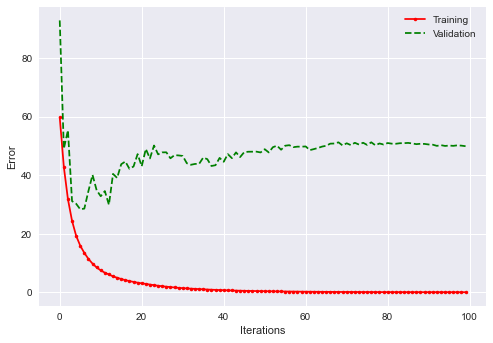

In [8]:
from matplotlib import pyplot as plt

# Line Plots
plt.style.use("seaborn")
plt.plot(ev['training']['l2'],color='red',label="Training",marker='.')
plt.plot(ev['valid_1']['l2'],color='green',label="Validation",linestyle="dashed",marker='+')
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.legend()
plt.show()

## How to fix Overfitting!

### Cross-Validation + Simplified Model

In [9]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

I opted for doing the **kfolds cross validation method** mixed with the **simplified model method** since it goes over the whole dataset each time and i guess that's a good thing

In [10]:
# determining the kfold indices to split into training and testing sets
kf = KFold(n_splits = 10, shuffle = True) # shuffle set to true because google said its better

# i used the Linear Regression model instead of the given Decision Tree
lin_model = LinearRegression()

# Transforming the Y 1d array into a dataframe for future purposes
Yd = pd.DataFrame(Y)

scores_table = []

for i in range(10):
    result = next(kf.split(X), None) # goes over the next holdout fold in each iteration
    
    x_test = X.iloc[result[1]]  # special boi (or holdout fold in formal terms)
    x_train = X.iloc[result[0]] # rest of the data

    y_test = Yd.iloc[result[1]] # the future -now present- purposes
    y_train = Yd.iloc[result[0]]

    model = lin_model.fit(x_train,y_train) #fitting the model to the fold's train set
    y_predict = lin_model.predict(x_test) #predictions

    mse = mean_squared_error(y_test, y_predict)
    mae = mean_absolute_error(y_test, y_predict)
    scores_table.append({"Accuracy Score" : model.score(x_test,y_test), "MSE" : mse, "MAE" : mae }) #model's performance on holdout fold

here are the scores for the kfold approach:

In [11]:
for i in range(5): # only printing out the first five iterations
    s = '\n'.join(i[0]+ ' : ' + str(i[1]) for i in list(scores_table[i].items()))
    print(f"- Score Table of iteration n°{i+1}:\n{s}\n")

accuracy_mean = np.mean(list(map(lambda x: x["Accuracy Score"],scores_table)))
mse_mean = np.mean(list(map(lambda x: x["MSE"],scores_table)))
mae_mean = np.mean(list(map(lambda x: x["MAE"],scores_table)))

print('\033[1m' + f"Mean Values: \nAccuracy Score : {round(accuracy_mean,3)*100}%\t\tMSE : {mse_mean}\t\tMAE : {mae_mean}" + '\033[1m')

- Score Table of iteration n°1:
Accuracy Score : 0.732597368517247
MSE : 15.319764665765419
MAE : 3.0930550608502663

- Score Table of iteration n°2:
Accuracy Score : 0.6756076485613043
MSE : 20.197931029767833
MAE : 3.130592369784083

- Score Table of iteration n°3:
Accuracy Score : 0.7646857612131192
MSE : 20.111290444084034
MAE : 3.271695380187051

- Score Table of iteration n°4:
Accuracy Score : 0.7012729485914677
MSE : 21.69701021072001
MAE : 3.604428216042528

- Score Table of iteration n°5:
Accuracy Score : 0.7965296564659616
MSE : 15.124831442232315
MAE : 2.9428592051662923

Mean Values: 
Accuracy Score : 71.3%		MSE : 23.986559543040656		MAE : 3.384326947235509


**Early stopping** *(in an iterative learning process)* and **Regularization** *(forcibly simplifying the model. for Linear-Reg by adding a penalty parameter to the cost fct)* are also alternate techniques to simplify the model and thereby make it more general.